In [79]:
import xarray as xr
import sys
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from tensorflow.keras.callbacks import Callback
import numpy as np
import tensorflow as tf
from functools import partial

AUTOTUNE = tf.data.experimental.AUTOTUNE
from dask.diagnostics import ProgressBar
import pandas as pd
import tensorflow.keras.layers as layers
import json
from tensorflow.keras.optimizers import Adam
from tensorflow._api.v2.distribute import MirroredStrategy
from tensorflow.keras import layers
import datetime
import tqdm
import time
import argparse


ERROR 1: PROJ: proj_create_from_database: Open of /nesi/project/niwa00018/rampaln/envs/ml_env_v2/share/proj failed
2025-07-10 02:45:50.626077: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [91]:
os.chdir(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/diffusion_models_byrn')

In [ ]:
argparser = argparse.ArgumentParser()
argparser.add_argument("--dev", action="store_true", help="use default dev config instead of default hpc config")
argparser.add_argument("--config", type=str, help="target path (eval config file) to use", required=False)
argparser.add_argument("--gan", action="store_true", help="must be enabled if using a GAN model")
argparser.add_argument("target", type=str, help="target path (model/train config file) to use")


In [80]:
config_file = r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/diffusion_models_byrn/models/Future_Hist_trained_Diffusion2_1000-0.0001-0.02_0.01pr_ACCESS-CM2/config_info.json'
#config_file = sys.argv[-1]
with open(config_file, 'r') as f:
    config = json.load(f)

In [82]:
config_file_for_test_data  = r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/diffusion_models_byrn/model_inference/metadata_ACCESS-CM2_diffusion.json'
# if args.config:
#     config_file_for_test_data = args.config
# elif args.dev:
#     config_file_for_test_data = r'./model_inference/metadata_all_gcms_v3_diffusion_dev.json'
# else:
#     config_file_for_test_data = r'./model_inference/metadata_all_gcms_v3_diffusion.json'
# # if sys.argv[-2] == '--dev':
# #     config_file_for_test_data = r'./model_inference/metadata_all_gcms_v3_diffusion_dev.json'

In [84]:

with open(config_file_for_test_data) as f:
    config_test_data = json.load(f)

USING_GAN = False

output_norm = 1

In [ ]:
quantiles = [ 0.5 , 0.7, 0.9, 0.925,
             0.95, 0.975, 0.98, 0.99,
             0.995, 0.998, 0.999, 0.9999]

In [85]:
# 30 y period
historical_period = slice("1985","2014")
future_period = slice("2070","2099")


In [86]:
sys.path.append(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/diffusion_models_byrn')
from src.layers import *
from src.models import *
from src.gan import *
from src.process_input_training_data import *
from src.dm import ResidualDiffusion, DiffusionSchedule, EDMSchedule, PredictionCallbackDiffusion
from src.models_dm import build_diffusion_unet, build_diffusion_unet_v2, build_edm_unet, get_custom_dm_objects

In [87]:



def load_model_dm(model_name, model_dir, epoch=None, gan=False):
    if epoch is None:
        epoch_suffix = 'final'
    else:
        epoch_suffix = f'epoch_{epoch}'

    dm_path = f'{model_dir}/{model_name}/ema_generator_{epoch_suffix}.h5'
    dm_path_alt = f'{model_dir}/{model_name}/generator_{epoch_suffix}.h5'
    unet_path = f'{model_dir}/{model_name}/unet_{epoch_suffix}.h5'

    custom_objects_unet = {"BicubicUpSampling2D": BicubicUpSampling2D,
                        "SymmetricPadding2D": SymmetricPadding2D}
    custom_objects_dm_or_gan = get_custom_dm_objects() if not gan else custom_objects_unet

    if os.path.exists(dm_path):
        dm = tf.keras.models.load_model(dm_path,
                                        custom_objects=custom_objects_dm_or_gan,
                                        compile=False)
    else:
        dm = tf.keras.models.load_model(dm_path_alt,
                                        custom_objects=custom_objects_dm_or_gan,
                                        compile=False)
    
    with open(f'{model_dir}/{model_name}/config_info.json') as f:
        config = json.load(f)

        unet = tf.keras.models.load_model(unet_path, custom_objects=custom_objects_unet
                                          , compile=False)

    return dm, unet, config["ad_loss_factor"]

def preprocess_input_data_eval(config: dict, match_index = True):
    vegt, orog, he = prepare_static_fields(config)
    means = xr.open_dataset(config["mean"])
    stds = xr.open_dataset(config["std"])

    X = xr.open_dataset(config["train_x"])  # .sel(time = slice("2016", None))
    X['time'] = pd.to_datetime(X.time.dt.strftime("%Y-%m-%d"))

    y = xr.open_dataset(config["train_y"])#, chunks={"time": 5000})
    y['time'] = pd.to_datetime(y.time.dt.strftime("%Y-%m-%d"))# .sel(time = slice("2016", None))

    # LOCAL CHANGE
    if config.get("gcms_for_eval") and config.get("output_varname"):
        gcms = config["gcms_for_eval"]
        y = y[[config["output_varname"]]]
        y = y.sel(GCM=gcms)
        X = X.sel(GCM=gcms)

    try:
        y = y.drop("lat_bnds")
        y = y.drop("lon_bnds")

    except:
        pass

    # preare the training data
    stacked_X, y = prepare_training_data(config, X, y, means, stds, match_index = match_index)

    return stacked_X, y, vegt, orog, he

def compute_quantiles(df,quantiles, period):
    df = df.sel(time = period)
    # this removes instances which have negative precipitation (os the minimum value is -0.0001) 
    # due to the leakyrelu activation function in GANs
    df = df.where(df>0.0, 0.0)
    seasonal_rainfall = df.groupby('time.season').mean()
    df = df.where(df>1, np.nan)
    quantiled_rain = df.quantile(q = quantiles, dim =["time"], skipna =True)
    return quantiled_rain, seasonal_rainfall


def compute_signal(df, quantiles, historical_period, future_period):

    historical_quantiles, seasonal_rainfall = compute_quantiles(df, quantiles, historical_period)
    future_quantiles, future_rainfall = compute_quantiles(df, quantiles, future_period)

    cc_signal = 100 * (future_rainfall - seasonal_rainfall)/seasonal_rainfall
    signal = 100 * (future_quantiles - historical_quantiles)/historical_quantiles
    historical_quantiles = historical_quantiles.rename({"pr":"hist_quantiles"})
    future_quantiles = future_quantiles.rename({"pr": "future_quantiles"})
    seasonal_rainfall = seasonal_rainfall.rename({"pr":"hist_clim_rainfall"})
    future_rainfall = future_rainfall.rename({"pr":"future_clim_rainfall"})
    signal = signal.rename({"pr":"cc_signal"})
    cc_signal = cc_signal.rename({"pr":"seas_cc_signal"})
    dset = xr.merge([historical_quantiles, future_quantiles,
                     signal, cc_signal, seasonal_rainfall, future_rainfall])
    return dset

def create_output(X, y):
    y = y.isel(time=0).drop("time")
    y = y.expand_dims({"time": X.time.size})
    y['time'] = (('time'), X.time.to_index())
    return y

def expand_conditional_inputs(X, batch_size):
    expanded_image = tf.expand_dims(X, axis=0)  # Shape: (1, 172, 179)

    # Repeat the image to match the desired batch size
    expanded_image = tf.repeat(expanded_image, repeats=batch_size, axis=0)  # Shape: (batch_size, 172, 179)

    # Create a new axis (1) on the last axis
    expanded_image = tf.expand_dims(expanded_image, axis=-1)
    return expanded_image

            # orog_vector = self.wgan.expand_conditional_inputs(self.orog, self.batch_size)
            # #average_combined, orog_vector,time_of_year_combined, spatial_means_combined,
            # #                 spatial_stds_combined
            # unet_prediction = self.unet.predict([
            #                               self.x_input[0].values[:self.batch_size], orog_vector[:self.batch_size]], verbose=0)

            # gan_prediction = self.generator.predict([random_latent_vectors,random_latent_vectors1,
            #                               self.x_input[0], orog_vector,unet_prediction])
            #
            # VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV

In [99]:
@tf.function
def predict_batch_residual(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type, scheduler=None):
    if model_type == 'GAN':
        intermediate = unet([data_batch, orog], training=False)
        # intermediate = unet([latent_vectors[0], data_batch, orog, he, vegt], training=False)
        # intermediate = apply_gaussian_blur(intermediate, size=7, sigma=1.5)
        # max_value = tf.reduce_max(intermediate, axis=(1, 2, 3), keepdims=True)
        # min_value = tf.reduce_min(intermediate, axis=(1, 2, 3), keepdims=True)
        init_prediction = intermediate
        # print(intermediate)
        # intermediate = tf.cast(tf.math.sqrt(tf.clip_by_value(intermediate, clip_value_min=0, clip_value_max=2500)), 'float32')
        residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, init_prediction], training=False)
        # return model([latent_vectors[0], data_batch, orog, he, vegt, init_prediction],
        #              training=False) + intermediate  # +
        return intermediate + residual_pred
    if model_type == 'diffusion':
        intermediate = unet([data_batch, orog], training=False)

        if isinstance(scheduler, DiffusionSchedule):
            batch_size = data_batch.shape[0]
            residual_pred = tf.random.normal(shape=(batch_size, 172, 179, 1))
            for t in reversed(range(scheduler.timesteps)):
                t_tensor = tf.fill((batch_size, 1), t)

                eps_theta = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)
                
                beta_t = scheduler.beta[t]
                alpha_t = scheduler.alpha[t]
                alpha_bar_t = scheduler.alpha_bar[t]

                residual_pred = 1.0 / tf.sqrt(alpha_t) * (residual_pred - (beta_t / tf.sqrt(1 - alpha_bar_t)) * eps_theta)

                if t > 0:
                    eps = tf.random.normal(shape=(batch_size, 172, 179, 1))
                    residual_pred += tf.sqrt(beta_t) * eps

            return intermediate + residual_pred
        else:
            raise Exception("scheduler not defined")
    else:
        # return unet([latent_vectors[0], data_batch, orog, he, vegt], training=False)
        return unet([data_batch, orog], training=False)

In [144]:

import tensorflow as tf

# Assume DiffusionSchedule is a class or object with the following attributes:
# - timesteps: The total number of timesteps used during training (e.g., 1000)
# - alpha_bar: A tf.Tensor of shape (timesteps,) containing the cumulative product of alphas.
# - sqrt_one_minus_alpha_bar: A tf.Tensor of shape (timesteps,)

# --- MODIFIED INFERENCE FUNCTION ---
# I have updated this function to use a second-order solver, which will be much faster.

        return unet([data_batch, orog], training=False)

In [217]:
def predict_batch_residual_solver(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type,
                                   scheduler=None, solver="heun", num_inference_steps=10):
    if model_type == 'GAN':
        intermediate = unet([data_batch, orog], training=False)
        residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, intermediate], training=False)
        return intermediate + residual_pred

    if model_type != 'diffusion' or scheduler is None:
        raise Exception("A scheduler must be provided for diffusion model.")

    batch_size = tf.shape(data_batch)[0]
    residual_pred = tf.random.normal(shape=(batch_size, 172, 179, 1))
    timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, num_inference_steps), dtype=tf.int32)
    intermediate = unet([data_batch, orog], training=False)

    prev_eps = None

    for i in tf.range(num_inference_steps - 1):
        t = timesteps[i]
        t_next = timesteps[i+1]

        t_tensor = tf.fill([batch_size, 1], t)
        t_next_tensor = tf.fill([batch_size, 1], t_next)

        sqrt_alpha_t, sqrt_1ma_t = _get_alpha_tensors(scheduler, batch_size, t)
        sqrt_alpha_next, sqrt_1ma_next = _get_alpha_tensors(scheduler, batch_size, t_next)

        eps_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)

        if solver == "first":
            pred_x0 = _denoise_x0(residual_pred, eps_t, sqrt_alpha_t, sqrt_1ma_t)
            residual_pred = _step_to(pred_x0, eps_t, sqrt_alpha_next, sqrt_1ma_next)

        elif solver == "heun":
            # Use previous step for higher-order correction (Euler + correction)
            if prev_eps is None:
                eps_avg = eps_t
            else:
                eps_avg = (prev_eps + eps_t) / 2.0
            pred_x0 = _denoise_x0(residual_pred, eps_avg, sqrt_alpha_t, sqrt_1ma_t)
            residual_pred = _step_to(pred_x0, eps_avg, sqrt_alpha_next, sqrt_1ma_next)
            prev_eps = eps_t  # Save for next step

        else:
            raise ValueError(f"Unknown solver type: {solver}")

    return intermediate + residual_pred


In [655]:
config_test_data['gcms_for_eval'] = ['EC-Earth3']

In [656]:
stacked_X, y, vegt, orog, he = preprocess_input_data_eval(config_test_data, match_index=False)

<xarray.DataArray 'orog' ()>
array(1733.36035156) <xarray.DataArray 'he' ()>
array(1157.46264648) <xarray.DataArray 'vegt' ()>
array(17.00000763)


In [946]:
config_test_data

{'mean': '/nesi/project/niwa03712/group_shared/Emulator_training_data/normalization/all_gcm_spatial_means.nc',
 'std': '/nesi/project/niwa03712/group_shared/Emulator_training_data/normalization/all_gcm_spatial_stds.nc',
 'stds_output': '/nesi/project/niwa03712/group_shared/Emulator_training_data/normalization/all_gcm_stds_updated_21_09_24.nc',
 'means_output': '/nesi/project/niwa03712/group_shared/Emulator_training_data/normalization/all_gcm_means_updated_21_09_24.nc',
 'train_x': '/nesi/project/niwa03712/group_shared/Emulator_training_data/predictor_fields_hist_ssp370_merged_updated.nc',
 'train_y': '/nesi/project/niwa03712/group_shared/Emulator_training_data/target_fields_hist_ssp370_concat.nc',
 'src_path': '.',
 'var_names': ['q_500',
  'q_850',
  'u_500',
  'u_850',
  'v_500',
  'v_850',
  't_500',
  't_850'],
 'output_folder': './models',
 'model_name': 'Future_Hist_trained_Diffusion2',
 'time_period': 'future only',
 'notes': 'Just trained on the ACCESS-CM2 gcm trained on both h

In [657]:
dm, unet, adv_factor = load_model_dm(
    config["model_name"],
    config_test_data["output_folder"],
    epoch=config_test_data.get("eval_epoch", None),
    gan=USING_GAN)

In [365]:
config.get("diffusion_type")

'diffusion2'

In [108]:

generator_model_type = 'diffusion'
scheduler = DiffusionSchedule(timesteps=config["dm_timesteps"], beta_start=config["dm_beta_start"], beta_end=config["dm_beta_end"])
if config.get("diffusion_type") == "EDM":
    scheduler = EDMSchedule()

In [94]:
try:
    y = y.isel(GCM=0)[['pr']]
except:
    y =y[['pr']]


## Log sampling during training

In [905]:
def predict_batch_residual_solver(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type,
                                   scheduler=None, solver="second", num_inference_steps=100):
    if model_type == 'GAN':
        intermediate = unet([data_batch, orog], training=False)
        residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, intermediate], training=False)
        return intermediate + residual_pred

    if model_type != 'diffusion' or scheduler is None:
        raise Exception("A scheduler must be provided for diffusion model.")

    batch_size = tf.shape(data_batch)[0]
    residual_pred = tf.random.normal(shape=(batch_size, 172, 179, 1))
    timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, num_inference_steps), dtype=tf.int32)
    intermediate = unet([data_batch, orog], training=False)

    for i in tf.range(num_inference_steps - 1):
        t = timesteps[i]
        t_next = timesteps[i+1]
        t_mid = (t + t_next) // 2
        t_tensor = tf.fill([batch_size, 1], t)
        t_next_tensor = tf.fill([batch_size, 1], t_next)
        t_mid_tensor = tf.fill([batch_size, 1], t_mid)

        sqrt_alpha_t, sqrt_1ma_t = _get_alpha_tensors(scheduler, batch_size, t)
        sqrt_alpha_next, sqrt_1ma_next = _get_alpha_tensors(scheduler, batch_size, t_next)
        sqrt_alpha_mid, sqrt_1ma_mid = _get_alpha_tensors(scheduler, batch_size, t_mid)

        if solver == "first":
            eps = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)
            pred_x0 = _denoise_x0(residual_pred, eps, sqrt_alpha_t, sqrt_1ma_t)
            residual_pred = _step_to(pred_x0, eps, sqrt_alpha_next, sqrt_1ma_next)

        elif solver == "second":
            eps_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)
            pred_x0 = _denoise_x0(residual_pred, eps_t, sqrt_alpha_t, sqrt_1ma_t)
            pred_next = _step_to(pred_x0, eps_t, sqrt_alpha_next, sqrt_1ma_next)
            eps_next = model([pred_next, t_next_tensor, data_batch, orog, intermediate], training=False)
            eps_avg = (eps_t + eps_next) / 2.0
            pred_x0_corr = _denoise_x0(residual_pred, eps_avg, sqrt_alpha_t, sqrt_1ma_t)
            residual_pred = _step_to(pred_x0_corr, eps_avg, sqrt_alpha_next, sqrt_1ma_next)

        elif solver == "third":
            # Runge-Kutta 3rd-order (Simpson's rule inspired)
            eps_1 = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)
            pred_x0_1 = _denoise_x0(residual_pred, eps_1, sqrt_alpha_t, sqrt_1ma_t)
            x_mid = _step_to(pred_x0_1, eps_1, sqrt_alpha_mid, sqrt_1ma_mid)

            eps_2 = model([x_mid, t_mid_tensor, data_batch, orog, intermediate], training=False)
            pred_x0_2 = _denoise_x0(x_mid, eps_2, sqrt_alpha_mid, sqrt_1ma_mid)
            x_next = _step_to(pred_x0_2, eps_2, sqrt_alpha_next, sqrt_1ma_next)

            eps_3 = model([x_next, t_next_tensor, data_batch, orog, intermediate], training=False)

            eps_final = (1/6) * eps_1 + (4/6) * eps_2 + (1/6) * eps_3
            pred_x0_final = _denoise_x0(residual_pred, eps_final, sqrt_alpha_t, sqrt_1ma_t)
            residual_pred = _step_to(pred_x0_final, eps_final, sqrt_alpha_next, sqrt_1ma_next)

        elif solver == "fourth":
            # RK4 style (for experimental purposes — expensive!)
            k1 = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)
            pred_x0_k1 = _denoise_x0(residual_pred, k1, sqrt_alpha_t, sqrt_1ma_t)
            x_k2 = _step_to(pred_x0_k1, k1, sqrt_alpha_mid, sqrt_1ma_mid)

            k2 = model([x_k2, t_mid_tensor, data_batch, orog, intermediate], training=False)
            pred_x0_k2 = _denoise_x0(x_k2, k2, sqrt_alpha_mid, sqrt_1ma_mid)
            x_k3 = _step_to(pred_x0_k2, k2, sqrt_alpha_mid, sqrt_1ma_mid)

            k3 = model([x_k3, t_mid_tensor, data_batch, orog, intermediate], training=False)
            pred_x0_k3 = _denoise_x0(x_k3, k3, sqrt_alpha_mid, sqrt_1ma_mid)
            x_k4 = _step_to(pred_x0_k3, k3, sqrt_alpha_next, sqrt_1ma_next)

            k4 = model([x_k4, t_next_tensor, data_batch, orog, intermediate], training=False)

            eps_final = (1/6) * (k1 + 2*k2 + 2*k3 + k4)
            pred_x0_final = _denoise_x0(residual_pred, eps_final, sqrt_alpha_t, sqrt_1ma_t)
            residual_pred = _step_to(pred_x0_final, eps_final, sqrt_alpha_next, sqrt_1ma_next)

        else:
            raise ValueError(f"Unknown solver: {solver}")

    return intermediate + residual_pred

# def predict_batch_residual_solver(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type,
#                                    scheduler=None, solver="heun", num_inference_steps=10):
#     if model_type == 'GAN':
#         intermediate = unet([data_batch, orog], training=False)
#         residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, intermediate], training=False)
#         return intermediate + residual_pred
#     if model_type == 'UNet':
#         intermediate = unet([data_batch, orog], training=False)
#         #residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, intermediate], training=False)
#         return intermediate#intermediate + residual_pred

#     if model_type != 'diffusion' or scheduler is None:
#         raise Exception("A scheduler must be provided for diffusion model.")

#     batch_size = tf.shape(data_batch)[0]
#     residual_pred = tf.random.normal(shape=(batch_size, 172, 179, 1))
#     timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, num_inference_steps), dtype=tf.int32)
#     intermediate = unet([data_batch, orog], training=False)

#     for i in tf.range(num_inference_steps - 1):
#         t = timesteps[i]
#         t_next = timesteps[i + 1]

#         t_tensor = tf.fill([batch_size, 1], t)
#         t_next_tensor = tf.fill([batch_size, 1], t_next)

#         sqrt_alpha_t, sqrt_1ma_t = _get_alpha_tensors(scheduler, batch_size, t)
#         sqrt_alpha_next, sqrt_1ma_next = _get_alpha_tensors(scheduler, batch_size, t_next)

#         # ε_t = model(x_t, t)
#         eps_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)
#         pred_x0 = _denoise_x0(residual_pred, eps_t, sqrt_alpha_t, sqrt_1ma_t)
#         x_euler = _step_to(pred_x0, eps_t, sqrt_alpha_next, sqrt_1ma_next)

#         if solver == "first":
#             residual_pred = x_euler

#         elif solver == "heun":
#             # ε_t+1 = model(x_euler, t+1)
#             eps_next = model([x_euler, t_next_tensor, data_batch, orog, intermediate], training=False)
#             eps_avg = 0.5 * (eps_t + eps_next)
#             pred_x0_avg = _denoise_x0(residual_pred, eps_avg, sqrt_alpha_t, sqrt_1ma_t)
#             residual_pred = _step_to(pred_x0_avg, eps_avg, sqrt_alpha_next, sqrt_1ma_next)

#         elif solver == "heun2":
#             # Midpoint Heun (RK2 midpoint variant)
#             t_mid = (t + t_next) // 2
#             t_mid_tensor = tf.fill([batch_size, 1], t_mid)

#             sqrt_alpha_mid, sqrt_1ma_mid = _get_alpha_tensors(scheduler, batch_size, t_mid)

#             pred_x0_mid = _denoise_x0(residual_pred, eps_t, sqrt_alpha_t, sqrt_1ma_t)
#             x_mid = _step_to(pred_x0_mid, eps_t, sqrt_alpha_mid, sqrt_1ma_mid)
#             eps_mid = model([x_mid, t_mid_tensor, data_batch, orog, intermediate], training=False)

#             pred_x0_avg = _denoise_x0(residual_pred, eps_mid, sqrt_alpha_t, sqrt_1ma_t)
#             residual_pred = _step_to(pred_x0_avg, eps_mid, sqrt_alpha_next, sqrt_1ma_next)
#         elif solver == "heun3":
#             # Higher-order midpoint method (RK3-like with 2 model calls)
#             t_mid = (t + t_next) // 2
#             t_mid_tensor = tf.fill([batch_size, 1], t_mid)

#             sqrt_alpha_mid, sqrt_1ma_mid = _get_alpha_tensors(scheduler, batch_size, t_mid)

#             # Predictor step using eps_t
#             pred_x0_t = _denoise_x0(residual_pred, eps_t, sqrt_alpha_t, sqrt_1ma_t)
#             x_mid = _step_to(pred_x0_t, eps_t, sqrt_alpha_mid, sqrt_1ma_mid)

#             # Evaluate at midpoint
#             eps_mid = model([x_mid, t_mid_tensor, data_batch, orog, intermediate], training=False)

#             # Weighted average for higher-order accuracy
#             eps_comb = (3.0 / 4.0) * eps_mid + (1.0 / 4.0) * eps_t
#             pred_x0_avg = _denoise_x0(residual_pred, eps_comb, sqrt_alpha_t, sqrt_1ma_t)
#             residual_pred = _step_to(pred_x0_avg, eps_comb, sqrt_alpha_next, sqrt_1ma_next)
#         elif solver == "heun5":
#             # Fifth-order Heun-style method using Simpson-like weights (3 model calls)
#             t_mid = (t + t_next) // 2
#             t_tensor = tf.fill([batch_size, 1], t)
#             t_mid_tensor = tf.fill([batch_size, 1], t_mid)
#             t_next_tensor = tf.fill([batch_size, 1], t_next)

#             sqrt_alpha_mid, sqrt_1ma_mid = _get_alpha_tensors(scheduler, batch_size, t_mid)

#             # Stage 1: evaluate at t
#             eps_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)
#             pred_x0_t = _denoise_x0(residual_pred, eps_t, sqrt_alpha_t, sqrt_1ma_t)
#             x_mid = _step_to(pred_x0_t, eps_t, sqrt_alpha_mid, sqrt_1ma_mid)

#             # Stage 2: evaluate at midpoint
#             eps_mid = model([x_mid, t_mid_tensor, data_batch, orog, intermediate], training=False)
#             pred_x0_mid = _denoise_x0(x_mid, eps_mid, sqrt_alpha_mid, sqrt_1ma_mid)
#             x_next = _step_to(pred_x0_mid, eps_mid, sqrt_alpha_next, sqrt_1ma_next)

#             # Stage 3: evaluate at t+1
#             eps_next = model([x_next, t_next_tensor, data_batch, orog, intermediate], training=False)

#             # Simpson-Heun weight combination (emulates 5th order)
#             eps_comb = (1.0/6.0) * eps_t + (2.0/3.0) * eps_mid + (1.0/6.0) * eps_next
#             pred_x0_final = _denoise_x0(residual_pred, eps_comb, sqrt_alpha_t, sqrt_1ma_t)
#             residual_pred = _step_to(pred_x0_final, eps_comb, sqrt_alpha_next, sqrt_1ma_next)
#         else:
#             raise ValueError(f"Unknown solver type: {solver}")

#     return intermediate + residual_pred

import tensorflow as tf
#@tf.function
def predict_batch_residual_v2(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type, scheduler=None, num_inference_steps=35):
    """
    Generates predictions using the specified model type.

    For the 'diffusion' model_type, this function now implements a second-order
    predictor-corrector sampler (similar to Heun's method or DPM-Solver-2).
    This allows for a significant reduction in the number of inference steps
    (e.g., from 1000 to 20-50) compared to a first-order DDPM sampler,
    leading to much faster inference.

    Args:
        model: The main generative model (either a GAN or a diffusion model).
        unet: A U-Net model used for an initial prediction.
        latent_vectors: Latent vectors for the GAN model.
        data_batch: The input data batch (conditional input).
        orog, he, vegt: Additional conditional inputs.
        model_type: A string, either 'GAN' or 'diffusion'.
        scheduler: A scheduler object for the diffusion process.
        num_inference_steps (int): The number of steps for the diffusion sampler.
                                   A smaller number means faster inference. Defaults to 25.
    """
    if model_type == 'GAN':
        intermediate = unet([data_batch, orog], training=False)
        init_prediction = intermediate
        residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, init_prediction], training=False)
        return intermediate + residual_pred

    if model_type == 'diffusion':
        # The U-Net provides a base prediction. The diffusion model predicts the residual.
        intermediate = unet([data_batch, orog], training=False)

        if scheduler is not None:
            batch_size = tf.shape(data_batch)[0]
            # Start the reverse diffusion process from pure noise.
            residual_pred = tf.random.normal(shape=(batch_size, 172, 179, 1))

            # Create a schedule of timesteps to sample from. Instead of 1000 steps,
            # we'll take `num_inference_steps` evenly spaced steps.
            timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, num_inference_steps), dtype=tf.int32)

            # --- Second-Order Solver Loop ---
            # This loop iterates through the timesteps, taking larger, more accurate steps.
            for i in tf.range(num_inference_steps - 1):
                t = timesteps[i]
                t_next = timesteps[i+1]

                # --- Predictor Step ---
                # 1. Predict the noise at the current timestep `t`.
                t_tensor = tf.fill((batch_size, 1), t)
                eps_theta_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)

                # 2. Use the predicted noise to estimate the original data (x0).
                # This is the "denoising" step.
                # FIX: Removed the incorrect `tf.reshape`. The gathered values are scalars.
                # TensorFlow's broadcasting will handle the arithmetic with the batch correctly.
                alpha_bar_t = tf.gather(scheduler.alpha_bar, t)
                sqrt_one_minus_alpha_bar_t = tf.gather(scheduler.sqrt_one_minus_alpha_bar, t)
                sqrt_alpha_bar_t = tf.sqrt(alpha_bar_t)
                pred_x0 = (residual_pred - sqrt_one_minus_alpha_bar_t * eps_theta_t) / sqrt_alpha_bar_t

                # 3. Use the denoised `pred_x0` to take a first-order step to `t_next`.
                # This gives us an intermediate prediction for the next state.
                # FIX: Removed the incorrect `tf.reshape` here as well.
                alpha_bar_t_next = tf.gather(scheduler.alpha_bar, t_next)
                sqrt_one_minus_alpha_bar_t_next = tf.gather(scheduler.sqrt_one_minus_alpha_bar, t_next)
                sqrt_alpha_bar_t_next = tf.sqrt(alpha_bar_t_next)
                residual_pred_next_intermediate = sqrt_alpha_bar_t_next * pred_x0 + sqrt_one_minus_alpha_bar_t_next * eps_theta_t

                # --- Corrector Step ---
                # 4. Predict the noise at the intermediate state `t_next`.
                t_next_tensor = tf.fill((batch_size, 1), t_next)
                eps_theta_t_next = model([residual_pred_next_intermediate, t_next_tensor, data_batch, orog, intermediate], training=False)

                # 5. Average the noise from the original and intermediate states.
                # This average provides a more accurate estimate of the noise slope across the step.
                eps_theta_avg = (eps_theta_t + eps_theta_t_next) / 2.0

                # 6. Use the corrected (averaged) noise to take the final second-order step.
                pred_x0_corrected = (residual_pred - sqrt_one_minus_alpha_bar_t * eps_theta_avg) / sqrt_alpha_bar_t
                residual_pred = sqrt_alpha_bar_t_next * pred_x0_corrected + sqrt_one_minus_alpha_bar_t_next * eps_theta_avg

            # The final `residual_pred` is the denoised result at t=0.
            return intermediate + residual_pred
        else:
            raise Exception("A scheduler must be provided for the diffusion model.")
    else:
        # return unet([latent_vectors[0], data_batch, orog, he, vegt], training=False)
        return unet([data_batch, orog], training=False)
# def predict_batch_residual_v3(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type, scheduler=None, num_inference_steps=15):
#     """
#     Predicts using a higher-order predictor-corrector (Heun-style, ~4th-5th order effective)
#     for the diffusion model. Keeps the model calls low (2 per step) while improving accuracy.

#     Args:
#         model: The generative model (GAN or diffusion).
#         unet: U-Net for initial estimate.
#         latent_vectors: Latent inputs for GAN.
#         data_batch, orog, he, vegt: Conditioning inputs.
#         model_type: 'GAN' or 'diffusion'.
#         scheduler: Diffusion scheduler with alpha_bar and sqrt_* arrays.
#         num_inference_steps: Number of timesteps used in sampling (smaller = faster).
#     """
#     if model_type == 'GAN':
#         intermediate = unet([data_batch, orog], training=False)
#         residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, intermediate], training=False)
#         return intermediate + residual_pred

#     elif model_type == 'diffusion':
#         intermediate = unet([data_batch, orog], training=False)

#         if scheduler is None:
#             raise ValueError("Scheduler must be provided for diffusion models.")

#         batch_size = tf.shape(data_batch)[0]
#         residual_pred = tf.random.normal(shape=(batch_size, 172, 179, 1))
#         timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, num_inference_steps), tf.int32)

#         for i in tf.range(num_inference_steps - 1):
#             t = timesteps[i]
#             t_next = timesteps[i + 1]

#             # --- Predictor Step (Euler or low-order step)
#             t_tensor = tf.fill([batch_size, 1], t)
#             eps_theta_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)

#             alpha_bar_t = tf.gather(scheduler.alpha_bar, t)
#             sqrt_alpha_bar_t = tf.sqrt(alpha_bar_t)
#             sqrt_1m_alpha_bar_t = tf.gather(scheduler.sqrt_one_minus_alpha_bar, t)

#             pred_x0 = (residual_pred - sqrt_1m_alpha_bar_t * eps_theta_t) / sqrt_alpha_bar_t

#             alpha_bar_t_next = tf.gather(scheduler.alpha_bar, t_next)
#             sqrt_alpha_bar_t_next = tf.sqrt(alpha_bar_t_next)
#             sqrt_1m_alpha_bar_t_next = tf.gather(scheduler.sqrt_one_minus_alpha_bar, t_next)

#             residual_pred_next_euler = sqrt_alpha_bar_t_next * pred_x0 + sqrt_1m_alpha_bar_t_next * eps_theta_t

#             # --- Corrector Step (Heun or midpoint average for higher accuracy)
#             t_next_tensor = tf.fill([batch_size, 1], t_next)
#             eps_theta_t_next = model([residual_pred_next_euler, t_next_tensor, data_batch, orog, intermediate], training=False)

#             # Heun-style averaging for noise slope
#             eps_theta_avg = (eps_theta_t + eps_theta_t_next) / 2.0

#             # Refined x0 using average noise (acts like 3rd–4th order method)
#             pred_x0_corrected = (residual_pred - sqrt_1m_alpha_bar_t * eps_theta_avg) / sqrt_alpha_bar_t

#             # Final residual update
#             residual_pred = sqrt_alpha_bar_t_next * pred_x0_corrected + sqrt_1m_alpha_bar_t_next * eps_theta_avg

#         return intermediate + residual_pred

#     else:
#         return unet([data_batch, orog], training=False)
import tensorflow as tf

import tensorflow as tf

def predict_batch_residual_v4(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type,
                               scheduler=None, num_inference_steps=35, final_clip_x0=True):
    """
    Higher-order, fast diffusion sampler inspired by DPM-Solver++(2M) with proper log-scaling.
    Designed for improved convergence and stability of precipitation predictions.

    Args:
        model: The diffusion model (epsilon predictor).
        unet: Conditional U-Net used to initialize prediction.
        latent_vectors: For GANs.
        data_batch: Climate input data (temp, humidity, etc).
        orog, he, vegt: Additional input features.
        model_type: 'GAN' or 'diffusion'.
        scheduler: DiffusionSchedule with precomputed coefficients.
        num_inference_steps: How many diffusion steps to take (e.g. 20-30).
        final_clip_x0: Whether to clip final prediction (e.g. rainfall) for stability.
    """
    if model_type == 'GAN':
        intermediate = unet([data_batch, orog], training=False)
        residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, intermediate], training=False)
        return intermediate + residual_pred

    elif model_type == 'diffusion':
        if scheduler is None:
            raise ValueError("Scheduler must be provided.")

        batch_size = tf.shape(data_batch)[0]
        intermediate = unet([data_batch, orog], training=False)
        residual_pred = tf.random.normal((batch_size, 172, 179, 1))

        # Use log-space time steps for better interpolation accuracy
        timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, num_inference_steps), tf.int32)
        log_alpha_bar = tf.math.log(scheduler.alpha_bar + 1e-6)

        for i in tf.range(num_inference_steps - 1):
            t = timesteps[i]
            t_next = timesteps[i + 1]

            t_tensor = tf.fill([batch_size, 1], t)
            t_next_tensor = tf.fill([batch_size, 1], t_next)

            eps_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)

            # Compute scalars
            alpha_bar_t     = tf.gather(scheduler.alpha_bar, t)
            alpha_bar_next  = tf.gather(scheduler.alpha_bar, t_next)
            log_alpha_t     = tf.gather(log_alpha_bar, t)
            log_alpha_next  = tf.gather(log_alpha_bar, t_next)

            sqrt_alpha_bar_t = tf.sqrt(alpha_bar_t)
            sqrt_1m_alpha_bar_t = tf.sqrt(1.0 - alpha_bar_t)

            # Estimate x0
            x0 = (residual_pred - sqrt_1m_alpha_bar_t * eps_t) / sqrt_alpha_bar_t

            # Predict x at t_next using current x0 + noise
            sqrt_alpha_bar_next = tf.sqrt(alpha_bar_next)
            sqrt_1m_alpha_bar_next = tf.sqrt(1.0 - alpha_bar_next)
            pred_t_next = sqrt_alpha_bar_next * x0 + sqrt_1m_alpha_bar_next * eps_t

            # Second model call
            eps_t_next = model([pred_t_next, t_next_tensor, data_batch, orog, intermediate], training=False)

            # Average the noise
            eps_avg = 0.5 * (eps_t + eps_t_next)

            # Final x0 correction
            x0_corrected = (residual_pred - sqrt_1m_alpha_bar_t * eps_avg) / sqrt_alpha_bar_t

            # Optional clipping here (at each step, or only final if extreme values remain)
            if final_clip_x0:
                x0_corrected = tf.clip_by_value(x0_corrected, -4, 4)  # adjust if needed

            # Next step
            residual_pred = sqrt_alpha_bar_next * x0_corrected + sqrt_1m_alpha_bar_next * eps_avg

        return intermediate + residual_pred

    else:
        return unet([data_batch, orog], training=False)

def predict_batch_residual_ddim_multi_step(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type,
                                           scheduler=None, num_inference_steps=50, final_clip_x0=True):
    """
    Deterministic DDIM-style inference over fewer timesteps, adapted from SinSR ideas.
    Fast and stable inference without noise injection, suitable for distilled or teacher-free usage.
    """
    if model_type == 'GAN':
        intermediate = unet([data_batch, orog], training=False)
        residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, intermediate], training=False)
        return intermediate + residual_pred

    elif model_type == 'diffusion':
        if scheduler is None:
            raise ValueError("Scheduler must be provided.")

        batch_size = tf.shape(data_batch)[0]
        intermediate = unet([data_batch, orog], training=False)
        residual_pred = tf.random.normal((batch_size, 172, 179, 1))

        # Linearly or logarithmically spaced timesteps
        timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, num_inference_steps), tf.int32)

        for i in tf.range(num_inference_steps - 1):
            t = timesteps[i]
            t_next = timesteps[i + 1]

            t_tensor = tf.fill([batch_size, 1], t)

            # Predict noise (epsilon) using current residual
            eps_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)

            # Extract scheduler values
            alpha_bar_t = tf.gather(scheduler.alpha_bar, t)
            alpha_bar_next = tf.gather(scheduler.alpha_bar, t_next)

            sqrt_alpha_bar_t = tf.sqrt(alpha_bar_t)
            sqrt_1m_alpha_bar_t = tf.sqrt(1.0 - alpha_bar_t)
            sqrt_alpha_bar_next = tf.sqrt(alpha_bar_next)
            sqrt_1m_alpha_bar_next = tf.sqrt(1.0 - alpha_bar_next)

            # Estimate x0 deterministically
            x0 = (residual_pred - sqrt_1m_alpha_bar_t * eps_t) / sqrt_alpha_bar_t
            if final_clip_x0:
                x0 = tf.clip_by_value(x0, -4.0, 4.0)

            # DDIM deterministic update (no noise injection)
            residual_pred = sqrt_alpha_bar_next * x0 + sqrt_1m_alpha_bar_next * eps_t

        return intermediate + residual_pred

    else:
        return unet([data_batch, orog], training=False)



def predict_parallel_resid(model, unet, inputs, output_shape, batch_size, orog_vector, he_vector, vegt_vector,
                           model_type='GAN', output_add_factor =1, scheduler=None):
    n_iterations = inputs.shape[0] // batch_size
    remainder = inputs.shape[0] - n_iterations * batch_size

    dset = []

    with tqdm.tqdm(total=n_iterations, desc="Predicting", unit="batch") as pbar:
        for i in range(n_iterations):
            data_batch = inputs[i * batch_size: (i + 1) * batch_size]
            random_latent_vectors1 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[0].shape[1:]))
            #random_latent_vectors1 = tf.repeat(random_latent_vectors1, repeats=batch_size, axis=0)
            orog = expand_conditional_inputs(orog_vector, batch_size)
            he = expand_conditional_inputs(he_vector, batch_size)
            vegt = expand_conditional_inputs(vegt_vector, batch_size)
#             output = predict_batch_residual_solver(model, unet, [random_latent_vectors1], data_batch, orog, he, vegt,
#                                             model_type, scheduler=scheduler, solver ="second")
            output =predict_batch_residual_ddim_multi_step(model, unet, [random_latent_vectors1], data_batch, orog, he, vegt,
                                            model_type, scheduler=scheduler)
            print(output.shape)

            dset += (np.exp(output.numpy()[:, :, :, 0]) - output_add_factor).tolist()
            pbar.update(1)  # Update the progress bar

    if remainder != 0:
        random_latent_vectors1 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[0].shape[1:]))
        #random_latent_vectors1 = tf.repeat(random_latent_vectors1, repeats=batch_size, axis=0)
        orog = expand_conditional_inputs(orog_vector, remainder)
        he = expand_conditional_inputs(he_vector, remainder)
        vegt = expand_conditional_inputs(vegt_vector, remainder)

#         output = predict_batch_residual_solver(model, unet, [random_latent_vectors1[:remainder]],
#                                         inputs[inputs.shape[0] - remainder:], orog, he, vegt, model_type, scheduler=scheduler, solver ="second")
        output = predict_batch_residual_ddim_multi_step(model, unet, [random_latent_vectors1[:remainder]],
                                        inputs[inputs.shape[0] - remainder:], orog, he, vegt, model_type, scheduler=scheduler)

        dset += (np.exp(output.numpy()[:, :, :, 0]) - output_add_factor).tolist()
    output_shape['pr'].values = dset

    return output_shape

In [933]:
df = xr.open_dataset(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/data/q_era5_oper_pl_20200401-20200430.nc')

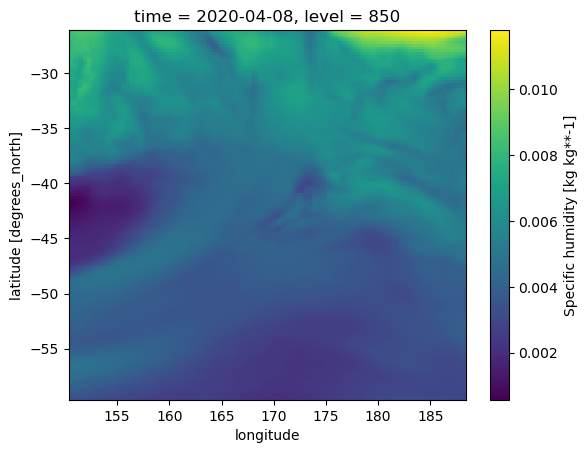

In [945]:
df.q.isel(level =0, time =7).plot()

In [891]:
timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, 45), tf.int32)

In [892]:
timesteps

<tf.Tensor: shape=(45,), dtype=int32, numpy=
array([999, 976, 953, 930, 908, 885, 862, 840, 817, 794, 771, 749, 726,
       703, 681, 658, 635, 613, 590, 567, 544, 522, 499, 476, 454, 431,
       408, 385, 363, 340, 317, 295, 272, 249, 227, 204, 181, 158, 136,
       113,  90,  68,  45,  22,   0], dtype=int32)>

In [906]:
historical_period = slice("2004","2004-02-01")

In [ ]:
5 * 30

In [ ]:
# 1 year is approximately 300 seconds, so multiply by 10 (3000 seconds for 10 years)
# 10 years appr

In [651]:
stacked_X

<xarray.DataArray 'q_500' (channel: 8, GCM: 1, time: 51135, lat: 23, lon: 26)>
array([[[[[-8.30745459e-01, -8.38590384e-01, -8.17659080e-01, ...,
           -6.30089164e-01, -5.40290177e-01, -7.86436379e-01],
          [-8.34893703e-01, -8.90437126e-01, -8.70701492e-01, ...,
           -6.11472845e-01, -5.92474282e-01, -8.70043755e-01],
          [-9.58111346e-01, -9.23698306e-01, -8.92962098e-01, ...,
           -5.66051602e-01, -5.91780722e-01, -6.73881650e-01],
          ...,
          [ 2.17229891e+00,  2.23127222e+00,  2.70833778e+00, ...,
           -7.84150302e-01, -8.35917175e-01, -8.50861371e-01],
          [ 5.19738019e-01,  5.88591814e-01,  9.38301861e-01, ...,
           -7.74686038e-01, -5.57640970e-01, -3.70473415e-01],
          [-3.38167697e-01, -4.34775203e-01, -5.74426651e-01, ...,
           -5.56972206e-01, -3.05101424e-01, -2.13176891e-01]],

         [[-8.70436549e-01, -8.97401869e-01, -8.49755883e-01, ...,
            1.99264780e-01,  3.74748409e-01,  5.51548660e-01],
          [-1.03640580e+00, -9.86318767e-01, -9.42093015e-01, ...,
            4.10579622e-01,  4.29395020e-01,  6.47314429e-01],
          [-9.50966954e-01, -9.75412309e-01, -9.00870502e-01, ...,
            3.87216002e-01,  4.60945159e-01,  5.65930367e-01],
...
            2.44136691e+00,  2.32185507e+00,  2.25141859e+00],
          [ 3.35616326e+00,  3.61932564e+00,  3.86894155e+00, ...,
            2.63661480e+00,  2.53852916e+00,  2.43981457e+00],
          [ 3.56483269e+00,  3.63835454e+00,  3.68429232e+00, ...,
            2.92036510e+00,  2.93934822e+00,  2.81674433e+00]],

         [[-1.63387954e+00, -1.66491532e+00, -1.68304026e+00, ...,
           -1.33017671e+00, -1.38721764e+00, -1.47308028e+00],
          [-1.35177994e+00, -1.45305574e+00, -1.50779736e+00, ...,
           -1.25604582e+00, -1.28686547e+00, -1.37051404e+00],
          [-1.03569686e+00, -1.06857336e+00, -1.19449174e+00, ...,
           -9.89621401e-01, -1.04343951e+00, -1.12524092e+00],
          ...,
          [ 2.74932098e+00,  2.99396539e+00,  3.18870878e+00, ...,
            2.76195025e+00,  2.83496094e+00,  2.82848263e+00],
          [ 2.94449663e+00,  3.16434121e+00,  3.33199215e+00, ...,
            2.58776188e+00,  2.69068837e+00,  2.76472759e+00],
          [ 3.24010324e+00,  3.71116209e+00,  3.70481491e+00, ...,
            2.76786518e+00,  2.67932343e+00,  2.64462590e+00]]]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-01-02 ... 2099-12-31
  * lon      (lon) float64 150.6 152.1 153.6 155.1 ... 183.6 185.1 186.6 188.1
  * lat      (lat) float64 -59.38 -57.88 -56.38 -54.88 ... -29.38 -27.88 -26.38
  * GCM      (GCM) object 'ACCESS-CM2'
  * channel  (channel) <U5 'q_500' 'q_850' 'u_500' ... 'v_850' 't_500' 't_850'

In [907]:
gcm = 'EC-Earth3'

# print(f"preparing data for a GCM {gcm}")

# if not os.path.exists(f'./outputs/{config["model_name"]}'):
#     os.makedirs(f'./outputs/{config["model_name"]}')

# with open(f'./outputs/{config["model_name"]}/config_info.json', 'w') as f:
#     json.dump(config, f)

output_shape = create_output(stacked_X, y).squeeze()
output_shape.pr.values = output_shape.pr.values * 0.0

inputs_hist = stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values
inputs_hist_len = len(inputs_hist)

#     output_hist_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_res_hist_bwar780.nc'
#     if not os.path.exists(output_hist_path):
timer_start = time.perf_counter()
output_hist4 = xr.concat([predict_parallel_resid(dm, unet,
                            inputs_hist,
                            output_shape.sel(time = historical_period), 32, orog.values, he.values, vegt.values,
                            model_type=generator_model_type, output_add_factor = output_norm, scheduler=scheduler) for i in range(5)], dim ="member")
# output_hist_unet = predict_parallel_resid(dm, unet,
#                             inputs_hist,
#                             output_shape.sel(time = historical_period), 32, orog.values, he.values, vegt.values,
#                             model_type='UNet', output_add_factor = output_norm, scheduler=scheduler)
timer_stop = time.perf_counter()
timer_elapsed = timer_stop - timer_start
print(f"Historical period - {generator_model_type} - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_hist_len:.6f} s/it, {inputs_hist_len} it)")



Predicting: 100%|██████████| 1/1 [00:23<00:00, 23.80s/batch]


(32, 172, 179, 1)


Predicting: 100%|██████████| 1/1 [00:23<00:00, 23.80s/batch]


(32, 172, 179, 1)


Predicting: 100%|██████████| 1/1 [00:23<00:00, 23.79s/batch]


(32, 172, 179, 1)


Predicting: 100%|██████████| 1/1 [00:23<00:00, 23.79s/batch]


(32, 172, 179, 1)


Predicting: 100%|██████████| 1/1 [00:23<00:00, 23.77s/batch]

(32, 172, 179, 1)
Historical period - diffusion - elapsed: 119.211775 s (3.725368 s/it, 32 it)


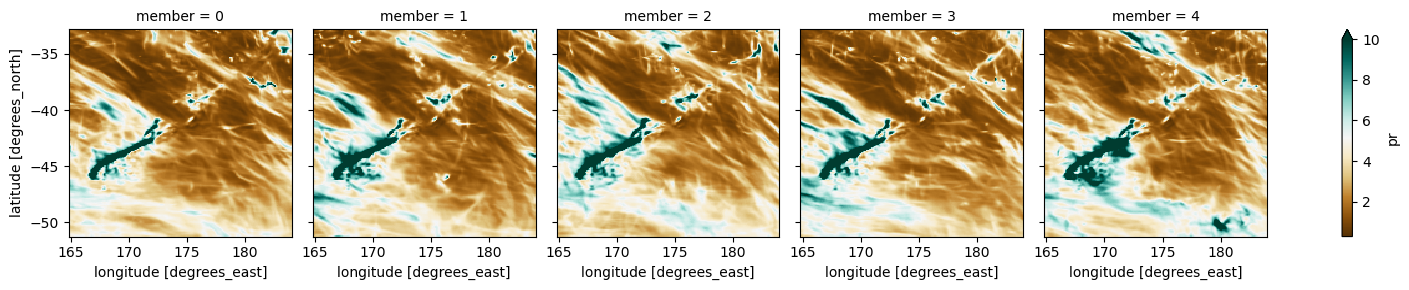

In [931]:
output_hist4.pr.mean("time").plot(col ="member", cmap ='BrBG', vmax =10)

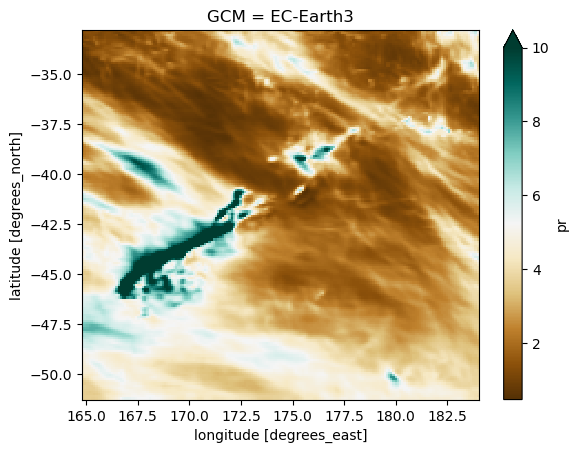

In [932]:
output_hist4.pr.mean(["time","member"]).plot( cmap ='BrBG', vmax =10)

In [928]:
output_hist4.isel(time =12, member =5).pr.plot(vmin =0, vmax =150)#.mean("time").pr.plot(vmin =0, vmax =10, cmap ='BrBG')

IndexError: index 5 is out of bounds for axis 0 with size 5

In [904]:
output_hist4.isel(time =61
                 ).pr.plot(vmin =0)

IndexError: index 61 is out of bounds for axis 0 with size 61

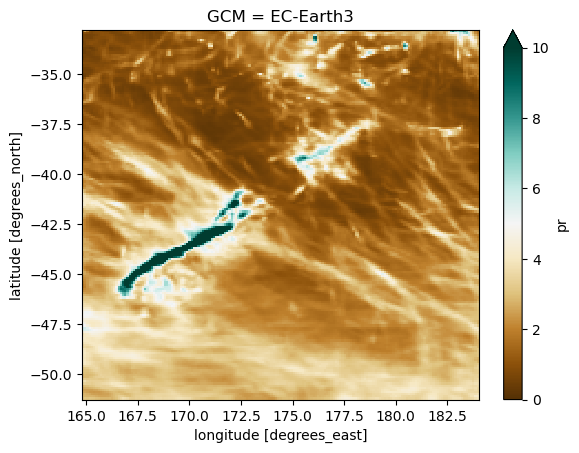

In [774]:
output_hist4.mean("time").pr.plot(vmin =0, vmax =10, cmap ='BrBG')

In [648]:
(40 * 6) * 100/3600

6.666666666666667

In [455]:
# 6 minutes per year?

3200

In [588]:
timer_start = time.perf_counter()
output_hist_unet = predict_parallel_resid(dm, unet,
                            inputs_hist,
                            output_shape.sel(time = historical_period), 32, orog.values, he.values, vegt.values,
                            model_type='UNet', output_add_factor = output_norm, scheduler=scheduler)
timer_stop = time.perf_counter()
timer_elapsed = timer_stop - timer_start
print(f"Historical period - {generator_model_type} - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_hist_len:.6f} s/it, {inputs_hist_len} it)")


Predicting:   0%|          | 0/11 [00:00<?, ?batch/s]

(32, 172, 179, 1)


Predicting:   9%|▉         | 1/11 [00:00<00:03,  3.06batch/s]

(32, 172, 179, 1)


Predicting:  18%|█▊        | 2/11 [00:00<00:02,  3.00batch/s]

(32, 172, 179, 1)


Predicting:  27%|██▋       | 3/11 [00:00<00:02,  3.05batch/s]

(32, 172, 179, 1)


Predicting:  36%|███▋      | 4/11 [00:01<00:02,  3.02batch/s]

(32, 172, 179, 1)


Predicting:  45%|████▌     | 5/11 [00:01<00:01,  3.00batch/s]

(32, 172, 179, 1)


Predicting:  55%|█████▍    | 6/11 [00:01<00:01,  3.04batch/s]

(32, 172, 179, 1)


Predicting:  64%|██████▎   | 7/11 [00:02<00:01,  3.02batch/s]

(32, 172, 179, 1)


Predicting:  73%|███████▎  | 8/11 [00:02<00:00,  3.01batch/s]

(32, 172, 179, 1)


Predicting:  82%|████████▏ | 9/11 [00:02<00:00,  3.05batch/s]

(32, 172, 179, 1)


Predicting:  91%|█████████ | 10/11 [00:03<00:00,  3.03batch/s]

(32, 172, 179, 1)


Predicting: 100%|██████████| 11/11 [00:03<00:00,  3.03batch/s]


Historical period - diffusion - elapsed: 5.381080 s (0.014662 s/it, 367 it)


In [590]:
output_hist

<xarray.Dataset>
Dimensions:  (time: 367, lat: 172, lon: 179)
Coordinates:
  * lon      (lon) float32 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0
  * lat      (lat) float32 -51.21 -51.11 -51.0 -50.89 ... -33.07 -32.97 -32.86
    GCM      <U10 'ACCESS-CM2'
  * time     (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2005-01-01
Data variables:
    pr       (time, lat, lon) float64 -0.1336 -0.1715 -0.1553 ... 0.4532 0.2343
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [716]:
output_hist2.max()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    GCM      <U9 'EC-Earth3'
Data variables:
    pr       float64 552.9

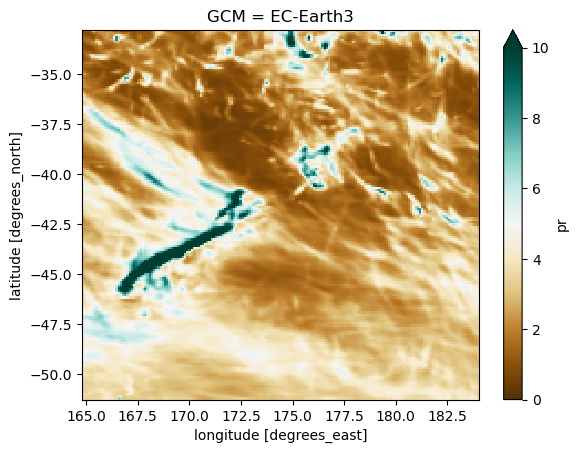

In [717]:
output_hist2.pr.mean('time').plot(vmin =0, vmax =10, cmap ='BrBG')

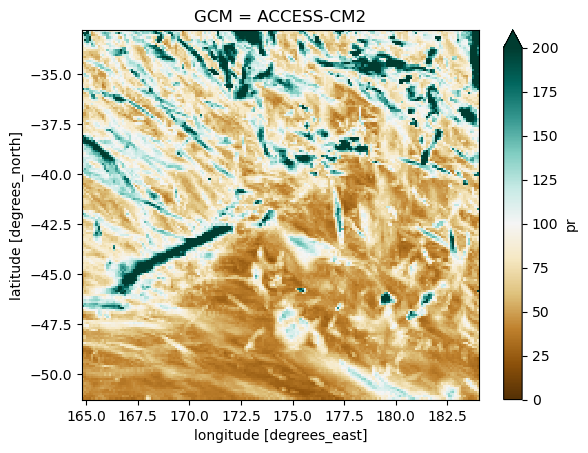

In [602]:
output_hist.pr.max('time').plot(vmin =0, vmax =200, cmap ='BrBG')

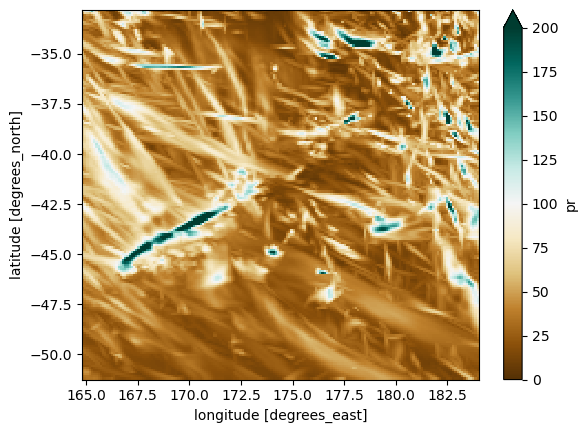

In [627]:
(df.pr.sel(time = slice("2004","2004-03-01")).max("time")*86400).plot(vmin =0, vmax =200, cmap ='BrBG')

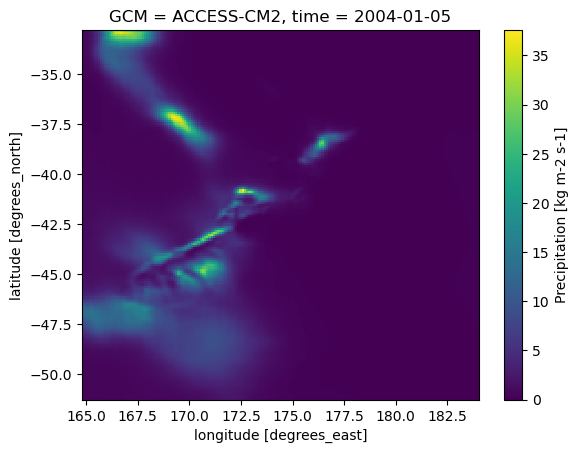

In [398]:
output_hist_unet.pr.isel(time =4).plot(vmin =0)

In [668]:
df = xr.open_dataset(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/EC-Earth3_hist_ssp370_pr_psl_tasmin_tasmax_sfcwind_sfcwindmax.nc')

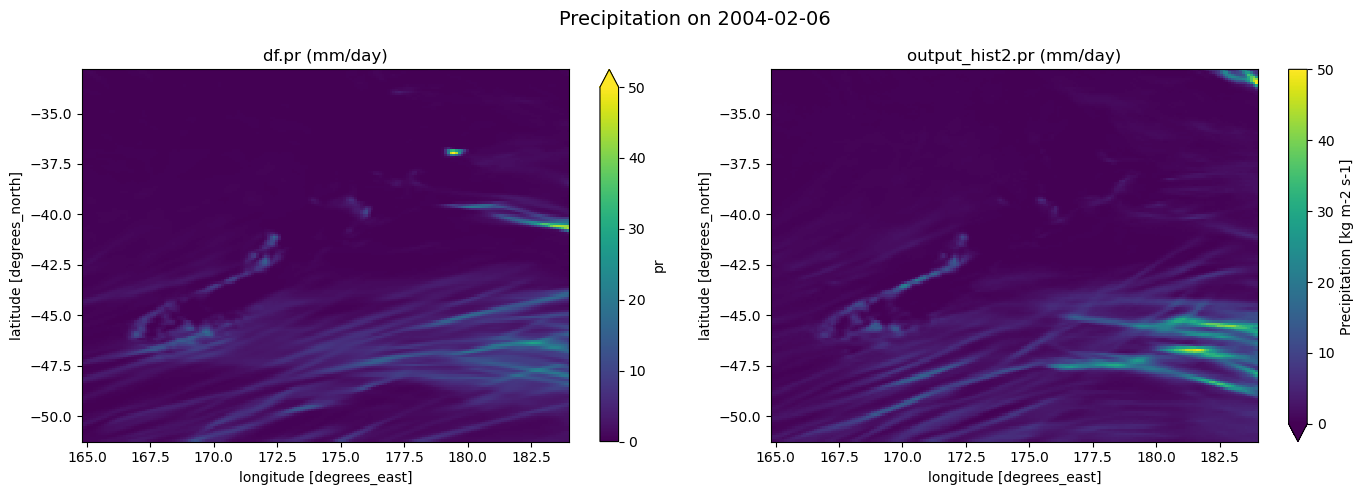

In [731]:
import matplotlib.pyplot as plt

# Select and convert to mm/day
pr1 = df.pr.sel(time="2004-02-12") * 86400
pr2 = output_hist2.pr.sel(time="2004-02-12")

# Determine common vmin/vmax for consistent scale
vmin = 0
vmax = 50#max(pr1.max().item(), pr2.max().item())  # or set manually, e.g., 100

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cmap = 'viridis'#"gist_ncar"  # Try 'cubehelix_r', 'PuBuGn', or 'jet' as alternatives
# Plot first
pr1.plot(ax=axes[0], cmap=cmap, vmin=vmin, vmax=vmax)
axes[0].set_title("df.pr (mm/day)")

# Plot second
pr2.plot(ax=axes[1], cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title("output_hist2.pr (mm/day)")

# Overall title
plt.suptitle("Precipitation on 2004-02-06", fontsize=14)

plt.tight_layout()
plt.show()



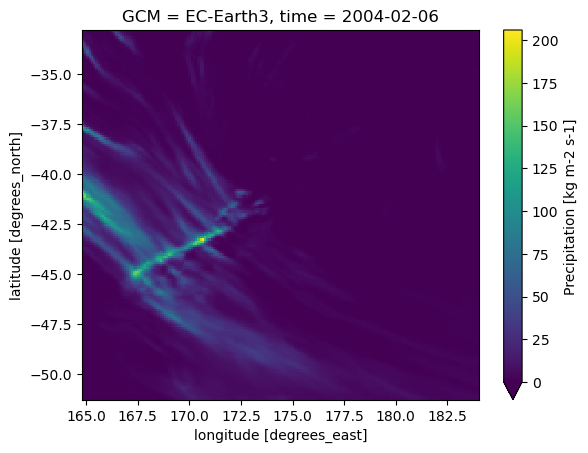

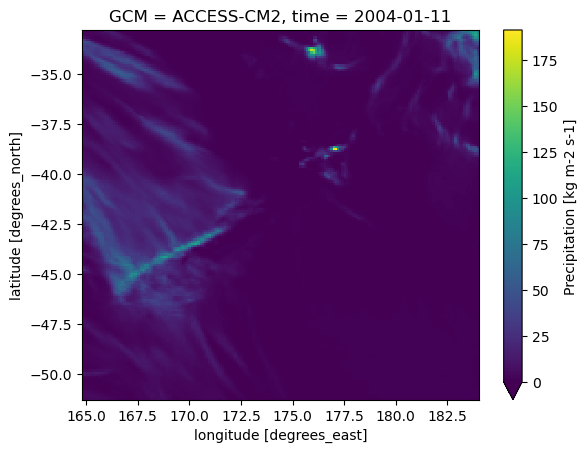

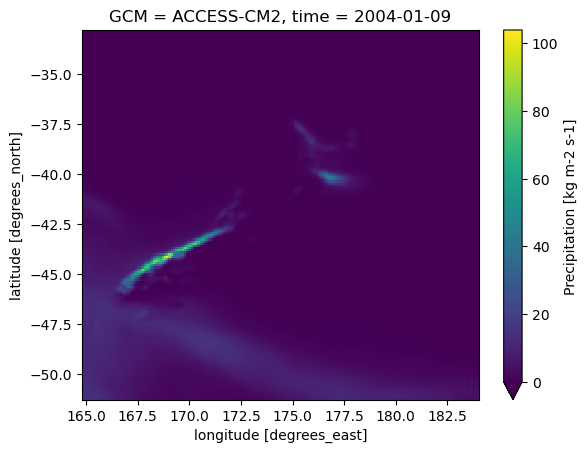

In [337]:
output_hist_unet.pr.isel(time =8).plot(vmin =0)

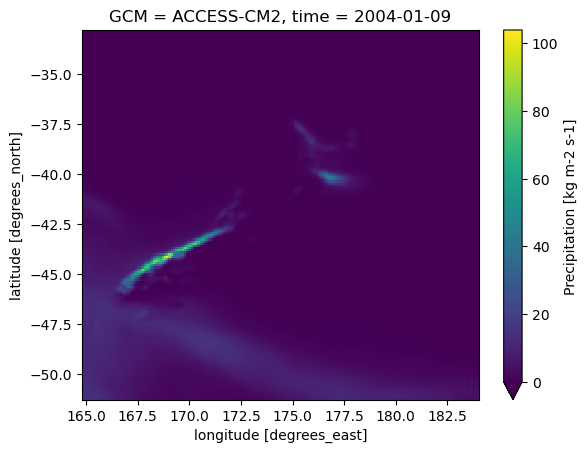

In [326]:
output_hist_unet.pr.isel(time =8).plot(vmin =0)

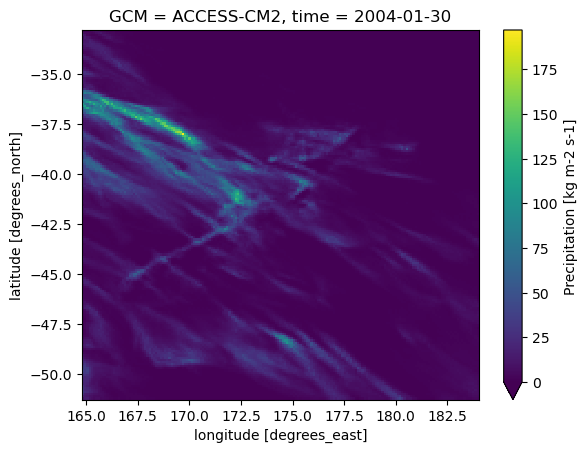

In [198]:
output_hist.pr.isel(time =29).plot(vmin =0)

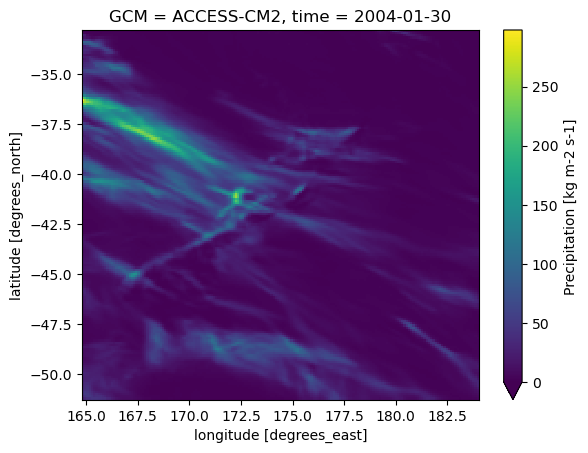

In [185]:
output_hist.pr.isel(time =29).plot(vmin =0)

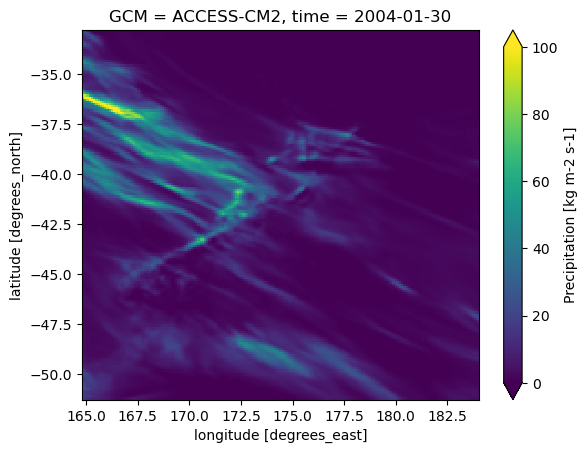

In [178]:
output_hist.pr.isel(time =29).plot(vmax =100, vmin =0)

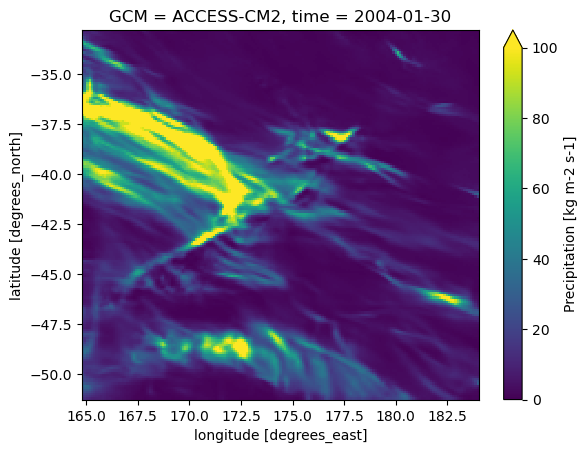

In [143]:
output_hist.pr.isel(time =29).plot(vmax =100, vmin =0)

In [ ]:
        output_hist.to_netcdf(output_hist_path)
        del output_hist
    else:
        print(f"Historical period - {generator_model_type} - skipped (netcdf file already exists)")


    output_hist_unet_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_hist_bwar780.nc'
    if not os.path.exists(output_hist_unet_path):
        timer_start = time.perf_counter()
        output_hist_unet = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_hist,
                                    output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values,
                                    model_type='UNET', output_add_factor = output_norm) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Historical period - unet only - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_hist_len:.6f} s/it, {inputs_hist_len} it)")

        output_hist_unet.to_netcdf(output_hist_unet_path)
        del output_hist_unet
    else:
        print("Historical period - unet only - skipped (netcdf file already exists)")

    del inputs_hist

    inputs_future = stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = future_period).values
    inputs_future_len = len(inputs_future)


    output_future_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_res_future_bwar780.nc'
    if not os.path.exists(output_future_path):
        timer_start = time.perf_counter()
        output_future = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_future,
                                    output_shape.sel(time = future_period), 64, orog.values, he.values, vegt.values,
                                    model_type=generator_model_type, output_add_factor = output_norm, scheduler=scheduler) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Future period - {generator_model_type} - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_future_len:.6f} s/it, {inputs_future_len} it)")

        output_future.to_netcdf(output_future_path)
        del output_future
    else:
        print(f"Future period - {generator_model_type} - skipped (netcdf file already exists)")


    output_future_unet_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_future_bwar780.nc'
    if not os.path.exists(output_future_unet_path):
        timer_start = time.perf_counter()
        output_future_unet = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_future,
                                    output_shape.sel(time = future_period), 64, orog.values, he.values, vegt.values,
                                    model_type='UNET', output_add_factor = output_norm) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Future period - unet only - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_future_len:.6f} s/it, {inputs_future_len} it)")

        output_future_unet.to_netcdf(output_future_unet_path)
        del output_future_unet
    else:
        print("Future period - unet only - skipped (netcdf file already exists)")

    del inputs_future

In [ ]:










    print(f"preparing data for a GCM {gcm}")

    if not os.path.exists(f'./outputs/{config["model_name"]}'):
        os.makedirs(f'./outputs/{config["model_name"]}')

    with open(f'./outputs/{config["model_name"]}/config_info.json', 'w') as f:
        json.dump(config, f)

    output_shape = create_output(stacked_X, y)
    output_shape.pr.values = output_shape.pr.values * 0.0
    
    inputs_hist = stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values
    inputs_hist_len = len(inputs_hist)

    output_hist_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_res_hist_bwar780.nc'
    if not os.path.exists(output_hist_path):
        timer_start = time.perf_counter()
        output_hist = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_hist,
                                    output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values,
                                    model_type=generator_model_type, output_add_factor = output_norm, scheduler=scheduler) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Historical period - {generator_model_type} - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_hist_len:.6f} s/it, {inputs_hist_len} it)")

        output_hist.to_netcdf(output_hist_path)
        del output_hist
    else:
        print(f"Historical period - {generator_model_type} - skipped (netcdf file already exists)")


    output_hist_unet_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_hist_bwar780.nc'
    if not os.path.exists(output_hist_unet_path):
        timer_start = time.perf_counter()
        output_hist_unet = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_hist,
                                    output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values,
                                    model_type='UNET', output_add_factor = output_norm) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Historical period - unet only - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_hist_len:.6f} s/it, {inputs_hist_len} it)")

        output_hist_unet.to_netcdf(output_hist_unet_path)
        del output_hist_unet
    else:
        print("Historical period - unet only - skipped (netcdf file already exists)")

    del inputs_hist

    inputs_future = stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = future_period).values
    inputs_future_len = len(inputs_future)


    output_future_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_res_future_bwar780.nc'
    if not os.path.exists(output_future_path):
        timer_start = time.perf_counter()
        output_future = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_future,
                                    output_shape.sel(time = future_period), 64, orog.values, he.values, vegt.values,
                                    model_type=generator_model_type, output_add_factor = output_norm, scheduler=scheduler) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Future period - {generator_model_type} - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_future_len:.6f} s/it, {inputs_future_len} it)")

        output_future.to_netcdf(output_future_path)
        del output_future
    else:
        print(f"Future period - {generator_model_type} - skipped (netcdf file already exists)")


    output_future_unet_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_future_bwar780.nc'
    if not os.path.exists(output_future_unet_path):
        timer_start = time.perf_counter()
        output_future_unet = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_future,
                                    output_shape.sel(time = future_period), 64, orog.values, he.values, vegt.values,
                                    model_type='UNET', output_add_factor = output_norm) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Future period - unet only - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_future_len:.6f} s/it, {inputs_future_len} it)")

        output_future_unet.to_netcdf(output_future_unet_path)
        del output_future_unet
    else:
        print("Future period - unet only - skipped (netcdf file already exists)")

    del inputs_future

    # # normalization is now with a 1
    # output_hist = xr.concat([predict_parallel_resid(dm, unet,
    #                                stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values,
    #                                output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values,
    #                                model_type='diffusion', output_add_factor = output_norm, scheduler=scheduler) for i in range(5)],
    #                         dim ="member")
    # output_hist_reg = xr.concat([predict_parallel_resid(dm, unet,
    #                                stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values,
    #                                output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values,
    #                                model_type='UNET', output_add_factor = output_norm) for i in range(1)],
    #                         dim ="member")

    # output_future = xr.concat([predict_parallel_resid(dm, unet,
    #                                      stacked_X.sel(GCM=gcm).transpose('time', 'lat', 'lon', 'channel').sel(
    #                                          time=future_period).values,
    #                                      output_shape.sel(time=future_period), 64, orog.values, he.values,
    #                                      vegt.values, model_type='diffusion', output_add_factor = output_norm, scheduler=scheduler) for i in range(5)], dim ="member")
    # output_future_reg = xr.concat([predict_parallel_resid(dm, unet,
    #                                      stacked_X.sel(GCM=gcm).transpose('time', 'lat', 'lon', 'channel').sel(
    #                                          time=future_period).values,
    #                                      output_shape.sel(time=future_period), 64, orog.values, he.values,
    #                                      vegt.values, model_type='UNET', output_add_factor = output_norm) for i in range(1)], dim ="member")
    
    # output_future2 = xr.concat([predict_parallel_resid(dm, unet,
    #                                      stacked_X.sel(GCM=gcm).transpose('time', 'lat', 'lon', 'channel').sel(
    #                                          time=future_period2).values,
    #                                      output_shape.sel(time=future_period2), 64, orog.values, he.values,
    #                                      vegt.values, model_type='diffusion', output_add_factor = output_norm, scheduler=scheduler) for i in range(5)], dim ="member")
    # output_future_reg2 = xr.concat([predict_parallel_resid(dm, unet,
    #                                      stacked_X.sel(GCM=gcm).transpose('time', 'lat', 'lon', 'channel').sel(
    #                                          time=future_period2).values,
    #                                      output_shape.sel(time=future_period2), 64, orog.values, he.values,
    #                                      vegt.values, model_type='UNET', output_add_factor = output_norm) for i in range(1)], dim ="member")
    # outputs = xr.concat([output_hist, output_future], dim ="time")
    # outputs_reg = xr.concat([output_hist_reg, output_future_reg], dim="time")
    # outputs_test = outputs.sel(time = slice("2098","2099"))
    # outputs_reg_test = outputs_reg.sel(time=slice("2098", "2099"))
    # outputs = compute_signal(outputs[['pr']], quantiles, historical_period, future_period)
    # outputs_reg = compute_signal(outputs_reg[['pr']], quantiles, historical_period, future_period)
    
    # outputs2 = xr.concat([output_hist, output_future2], dim ="time")
    # outputs_reg2 = xr.concat([output_hist_reg, output_future_reg2], dim="time")
    # outputs2 = compute_signal(outputs2[['pr']], quantiles, historical_period, future_period2)
    # outputs_reg2 = compute_signal(outputs_reg2[['pr']], quantiles, historical_period, future_period2)
    
    # #outputs.attrs['title'] = outputs.attrs['title'] + f'   /n ML Emulated NIWA-REMS GAN v1 GCM: {gcm}'
    # if not os.path.exists(f'./outputs/{config["model_name"]}'):
    #     os.makedirs(f'./outputs/{config["model_name"]}')
    # outputs.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_ens_v2.nc')
    # outputs_reg.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_v2.nc')
    # outputs2.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_ens_mid_century_v2.nc')
    # outputs_reg2.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_mid_century_v2.nc')
    # outputs_test.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_ens_test_sample_v2.nc')
    # outputs_reg_test.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_test_sample_v2.nc')
    # output_hist.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_res_hist_bwar780.nc')
    # output_hist_unet.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_hist_bwar780.nc')
    # output_future.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_res_future_bwar780.nc')
    # output_future_unet.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_future_bwar780.nc')

    # with open(f'./outputs/{config["model_name"]}/config_info.json', 'w') as f:
    #     json.dump(config, f)


In [70]:
df = xr.open_dataset(r'/nesi/project/niwa00018/bwar780/multi-variate-gan/outputs/Future_Hist_trained_Diffusion2_1000-0.0001-0.02_0.01pr_ACCESS-CM2/CCAM_NIWA-REMS_ACCESS-CM2_hist_ssp370_pr_res_hist_bwar780.nc')

In [71]:
df_future = xr.open_dataset(r'/nesi/project/niwa00018/bwar780/multi-variate-gan/outputs/Future_Hist_trained_Diffusion2_1000-0.0001-0.02_0.01pr_ACCESS-CM2/CCAM_NIWA-REMS_ACCESS-CM2_hist_ssp370_pr_res_future_bwar780.nc')

In [72]:
hist_climo = df.groupby('time.year').max().max("year")

In [73]:
future_climo = df_future.groupby('time.year').max().max("year")

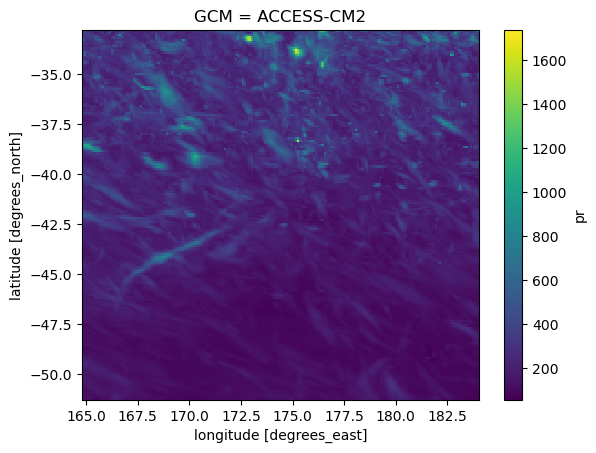

In [74]:
future_climo.pr.plot()

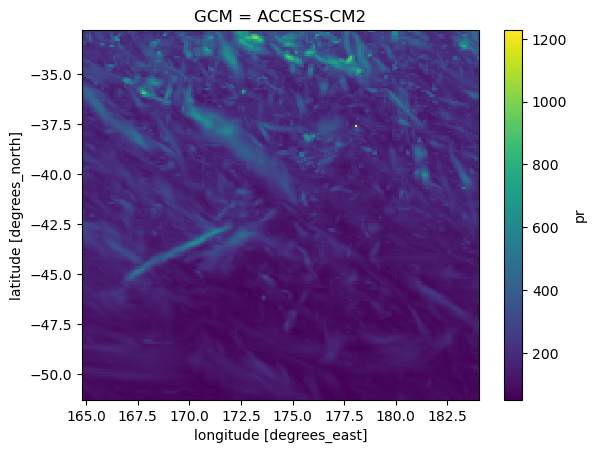

In [75]:
hist_climo.pr.plot()

In [76]:
cc_signal =100 * (future_climo - hist_climo)/hist_climo

In [77]:
cc_signal.pr.mean()

<xarray.DataArray 'pr' ()>
array(29.196846, dtype=float32)
Coordinates:
    GCM      <U10 'ACCESS-CM2'

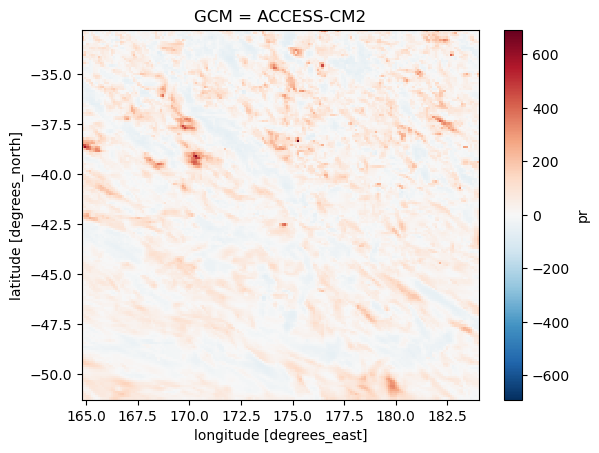

In [78]:
cc_signal.pr.plot()